# A Hybrid Ensemble Learning Approach to Star-galaxy Classification

[MNRAS (2015) 453 (1): 507-521](http://mnras.oxfordjournals.org/content/453/1/507), [arXiv:1505.02200](http://arxiv.org/abs/1505.02200) [astro-ph.IM]

## Abstract

There exist a variety of star-galaxy classification techniques, each with their own strengths and weaknesses. In this paper, we present a novel meta-classification framework that combines and fully exploits different techniques to produce a more robust star-galaxy classification. To demonstrate this hybrid, ensemble approach, we combine a purely morphological classifier, a supervised machine learning method based on random forest, an unsupervised machine learning method based on self-organizing maps, and a hierarchical Bayesian template fitting method. Using data from the CFHTLenS survey, we consider different scenarios: when a high-quality training set is available with spectroscopic labels from DEEP2, SDSS, VIPERS, and VVDS, and when the demographics of sources in a low-quality training set do not match the demographics of objects in the test data set. We demonstrate that our Bayesian combination technique improves the overall performance over any individual classification method in these scenarios. Thus, strategies that combine the predictions of different classifiers may prove to be optimal in currently ongoing and forthcoming photometric surveys, such as the Dark Energy Survey and the Large Synoptic Survey Telescope.

This notebook demonstrates an example of using Bayesian Model Combination (BMC) for the CFHTLenS data.

## Introduction

<img src="images/SGmag.png" width="500">

<center> Image: sample images of stars and galaxies from the SDSS survey at different magnitudes (source: [LCDM website](http://lcdm.astro.illinois.edu/)) </center>

The problem of source classification is fundamental to astronomy and goes as far back as [Messier (1781)](https://en.wikipedia.org/wiki/Charles_Messier). A variety of different strategies have been developed  to tackle this long-standing problem, and yet there is no consensus on the optimal star-galaxy classification strategy. The most commonly used method to classify stars and galaxies in large sky surveys is the morphological separation ([Sebok 1979](http://adsabs.harvard.edu/abs/1979AJ.....84.1526S); [Kron 1980](http://adsabs.harvard.edu/abs/1980ApJS...43..305K); [Valdes 1982](http://adsabs.harvard.edu/abs/1982SPIE..331..465V); [Yee 1991](http://adsabs.harvard.edu/abs/1991PASP..103..396Y); [Vasconcellos et al. 2011](http://adsabs.harvard.edu/abs/2011AJ....141..189V); [Henrion et al. 2011](http://adsabs.harvard.edu/abs/2011MNRAS.412.2286H)). It relies on the assumption that stars appear as point sources while galaxies appear as resolved sources. However, currently ongoing and upcoming large photometric surveys, such as the [Dark Energy Survey (DES)](http://www.darkenergysurvey.org/) and the [Large Synoptic Survey Telescope (LSST)](http://www.lsst.org/lsst/), will detect a vast number of unresolved galaxies at faint magnitudes. Near a survey's limit, the photometric observations cannot reliably separate stars from unresolved galaxies by morphology alone without leading to incompleteness and contamination in the star and galaxy samples.

The contamination of unresolved galaxies can be mitigated by using training based algorithms. Machine learning methods have the advantage that it is easier to include extra information, such as concentration indices, shape information, or different model magnitudes. However, they are only reliable within the limits of the training data, and it can be difficult to extrapolate these algorithms outside the parameter range of the training data. These techniques can be further categorized into supervised and unsupervised learning approaches.

In [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning), the input attributes (e.g. magnitudes or colors) are provided along with the truth labels (e.g. star or galaxy). [Odewahn et al. (1992)](http://adsabs.harvard.edu/abs/1992AJ....103..318O) pioneered the application of neural networks to the star-galaxy classification problem, and it has become a core part of the astronomical image processing software [_SExtractor_](http://www.astromatic.net/software/sextractor). Other successfully implemented examples include decision trees ([Weir, Fayyad, & Djorgovski (1995)](http://adsabs.harvard.edu/abs/1995AJ....109.2401W); [Suchkov, Hanisch, & Margon (2005)](http://adsabs.harvard.edu/abs/2005AJ....130.2439S); [Ball & Brunner (2006)](http://adsabs.harvard.edu/abs/2010IJMPD..19.1049B); [Sevilla-Noarbe & Etayo-Sotos (2015)](http://adsabs.harvard.edu/abs/2015A%26C....11...64S)) and Support Vector Machines ([Fadely, Hogg, & Willman 2012](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)). [Unsupervised machine learning](https://en.wikipedia.org/wiki/Unsupervised_learning) techniques are less common, as they do not utilize the truth labels during the training process, and only the input attributes are used.

Physically based template fitting methods have also been used for the star-galaxy classification problem ([Robin et al. 2007](http://adsabs.harvard.edu/abs/2007ApJS..172..545R); [Fadely, Hogg, & Willman 2012](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)). Template fitting approaches infer a source's properties by finding the best match between the measured set of magnitudes (or colors) and the synthetic set of magnitudes (or colors) computed from a set of spectral templates. Although it is not necessary to obtain a high-quality spectroscopic training sample,
these techniques do require a representative sample of theoretical or empirical templates that span the possible spectral energy distributions (SEDs) of stars and galaxies. Furthermore, they are not exempt from uncertainties due to measurement errors on the filter response curves, or from mismatches between the observed magnitudes and the template SEDs.

In [1]:
from __future__ import print_function, division, unicode_literals
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data: CFHTLens

We use photometric data from the [Canada-France-Hawaii Telescope Lensing Survey (CFHTLens)](http://www.cfhtlens.org/). This catalog consists of more than twenty five million objects with a limiting magnitude of $i_{\text{AB}} \approx 25.5$. It covers a total of 154 square degrees in the four fields (named W1, W2, W3, and W4) of [CFHT Legacy Survey (CFHTLS)](http://www.cfht.hawaii.edu/Science/CFHTLS/) observed in the five photometric bands: $u$, $g$, $r$, $i$, and $z$.

We have cross-matched reliable spectroscopic galaxies from the [Deep Extragalactic Evolutionary Probe Phase 2 (DEEP2)](http://deep.ps.uci.edu/), the [Sloan Digital Sky Survey Data Release 10 (SDSS-DR10)](https://www.sdss3.org/dr10/), the [VIsible imaging Multi-Object Spectrograph (VIMOS) Very Large Telescope (VLT) Deep Survey (VVDS)](http://cesam.oamp.fr/vvdsproject/vvds.htm), and the [VIMOS Public Extragalactic Redshift Survey (VIPERS)](http://vipers.inaf.it/). We have selected only sources with very secure redshifts and no bad flags (quality flags -1, 3, and 4 for DEEP2; quality flag 0 for SDSS; quality flags 3, 4, 23, and 24 for VIPERS and VVDS). In the end, we have 8,545 stars and 57,843 galaxies available for the training and testing processes. We randomly select 13,278 objects for the blind testing set, and use the remainder for training and cross-validation. While HB uses only the magnitudes in the five bands, $u$, $g$, $r$, $i$, and $z$, TPC and SOMc are trained with a total of 9 attributes: the five magnitudes and their corresponding colors, $u-g$, $g-r$, $r-i$, and $i-z$. The morphological separation method uses [_SExtractor_](http://www.astromatic.net/software/sextractor)'s  FLUX RADIUS parameter provided by the CFHTLenS catalog.

We use `pandas` to load the CFHTLenS data, using the object IDs as the index column.

In [2]:
df = pd.read_csv('../data/cfhtlens_matched.csv', index_col='id')

The CSV files have 100+ columns.

In [3]:
df.head()

,ALPHA_J2000,A_WORLD,BPZ_FILT,BPZ_FLAGFILT,BPZ_NONDETFILT,B_WORLD,BackGr,CHI_SQUARED_BPZ,CLASS_STAR,DELTA_J2000,...,n_exposures_detec,n_exposures_used,pos,scalelength,sp_cat,sp_cat_id,star_flag,true_class,weight,z_spec
id,,,,,,,,,,,,,,,,,,,,,
W3m0m1_11696,214.650267,0.000981,31,0,0,0.000760,0.002792,0.054,0.028628,53.106480,...,7,0,Position ICRS 214.6502668999999 53.10647969000003,0.0000,sdss-dr10,1.493031e+18,0,0,0.0000,0.202653
W3m0m1_13805,215.003288,0.000834,31,0,0,0.000602,0.011452,0.341,0.028643,53.112236,...,7,0,Position ICRS 215.00328799999977 53.1122355599...,0.0000,sdss-dr10,1.491820e+18,0,0,0.0000,0.200794
W3m0m1_14097,214.731917,0.001051,31,0,0,0.000762,0.017118,0.308,0.028655,53.108660,...,7,0,Position ICRS 214.7319170999998 53.10865952999999,0.0000,sdss-dr10,1.493029e+18,0,0,0.0000,0.114782
W3m0m1_14953,214.261103,0.000209,31,0,0,0.000175,-0.003837,0.100,0.028710,53.130319,...,7,0,Position ICRS 214.26110300000002 53.1303185000...,0.0000,sdss-dr10,5.648736e+18,0,0,0.0000,0.773710
W3m0m1_15171,214.211339,0.000205,31,0,0,0.000118,-0.004166,0.136,0.021400,53.132613,...,5,5,Position ICRS 214.21133930000028 53.1326129599...,3.1838,sdss-dr10,5.649857e+18,0,0,15.4507,0.948875


The object IDs of the training set used in the paper are stored in `clens_train_id.txt`. We used these indices to construct the same training set, since we will simply read the save results of TPC, SOMc, and HB from txt files, not run the base classifiers in this notebook.

In [4]:
train_id = pd.read_csv('../data/clens_train_id.txt')
train = df.loc[train_id.id]

test_id =pd.read_csv('../data/clens_test_id.txt')
test = df.loc[test_id.id]

It's useful to set aside the truth labels.

In [5]:
truth_train = train['true_class'].values
truth_test = test['true_class'].values

### Morphological classification

The simplest and perhaps the most widely used approach to star-galaxy classification is to make a hard cut in the space of photometric attributes. As a first-order morphological selection of point sources, we adopt a technique that is popular among the weak lensing community. 

In [6]:
r_h_cv = train.FLUX_RADIUS.values
mag_i_cv = train.MAG_i.values

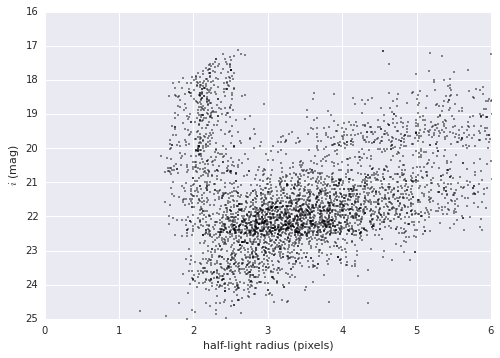

In [7]:
draw_box = False

mag_i_lower = 17
mag_i_upper = 21.0
r_h_lower = 1.4
r_h_upper = 2.8

# select a subset to make the plot not too crowded
rows = np.random.choice(xrange(len(r_h_cv)), size=5000)
plt.scatter(r_h_cv[rows], mag_i_cv[rows], marker='.', s=5, color='k')
plt.xlabel('half-light radius (pixels)')
plt.ylabel(r'$i$ (mag)')
plt.xlim(0, 6)
plt.ylim(16, 25)
plt.ylim(plt.ylim()[::-1])

if draw_box:
    plt.plot([r_h_upper, r_h_upper], [mag_i_lower, mag_i_upper], c = 'r')
    plt.plot([r_h_lower, r_h_lower], [mag_i_lower, mag_i_upper], c = 'r')
    plt.plot([r_h_lower, r_h_upper], [mag_i_upper, mag_i_upper], c = 'r')
    plt.plot([r_h_upper, r_h_lower], [mag_i_lower, mag_i_lower], c = 'r')

plt.show()

As figure shows, there is a distinct locus produced by point sources in the half-light radius (estimated by [SExtractor](http://www.astromatic.net/software/sextractor)'s FLUX RADIUS parameter) vs. the $i$-band magnitude plane. A rectangular cut in this size-magnitude plane separates point sources, which are presumed to be stars, from resolved sources, which are presumed to be galaxies. The boundaries of the selection box are determined by manually inspecting the size-magnitude diagram.

One of the disadvantages of such cut-based methods is that it classifies every source with absolute certainty. It is difficult to justify such a decisive classification near a survey's magnitude limits, where measurement uncertainties generally increase. A more informative approach is to provide probabilistic classifications. Although a recent work by [Henrion 2011](http://adsabs.harvard.edu/abs/2011MNRAS.412.2286H) implemented a probabilistic classification using a Bayesian approach on the morphological measurements alone, here we use a cut-based morphological separation to demonstrate the advantages of our combination techniques. In particular, we later show that the binary outputs (i.e., 0 or 1) of cut-based methods can be transformed into probability estimates by combining them with the probability outputs from other probabilistic classification techniques, such as TPC, SOMc, and HB.


A morphological classifier is simple to implement:

In [8]:
def morph_class(magnitude, half_radius, cut=[0, 25, 1.0, 3.0]):
    point_source = ((magnitude > cut[0]) & (magnitude < cut[1]) &
                    (half_radius > cut[2]) & (half_radius < cut[3]))
    return point_source.astype(np.int)

In [9]:
morph_cv = morph_class(mag_i_cv, r_h_cv, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

We use the same morphological classifier to separate stars from galaxies in the test set.

In [10]:
r_h_test = test.FLUX_RADIUS.values
mag_i_test = test.MAG_i.values

morph_test = morph_class(mag_i_test, r_h_test, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

### Trees for Probabilistic Classification (TPC)

[Carrasco Kind & Brunner (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.432.1483C)

TPC is a supervised machine learning technique, which is part of [Machine Learning for photo-Z (MLZ)](http://lcdm.astro.illinois.edu/static/code/mlz/MLZ-1.2/doc/html/) package.

<img src="images/example_tree.png" width="500">

<center> Image: A visual representation of a random forest (source: [TPZ: Trees for Photo-Z](http://pythonhosted.org/MLZ/tpz.html)) </center>

We used XSEDE computing resources to run TPC on TACC Stampede with the following parameters (unimportant parameters are omiitted):

- Att              : u, g, r, i, z, u-g, g-r, r-i, i-z
- PredictionMode   : TPZ_C
- PredictionClass  : Class
- MinZ             : 0
- MaxZ             : 1
- NzBins           : 2
- NRandom          : 5
- NTrees           : 100
- Natt             : 3
- OobError         : yes
- MinLeaf          : 5
- ImpurityIndex    : entropy

Here, we simply load the results, Out-of-Bag (OOB) and test prediction files.

In [11]:
tpc_cv = np.loadtxt('../paper/data/clens_tpc_oob.mlz', unpack=True, usecols=(2,))
tpc_test = np.loadtxt('../paper/data/clens_tpc_test.mlz', unpack=True, usecols=(2,))

### Self-Organizing Maps Classification (SOMc)

Carrasco-Kind & Brunner (2014)

SOMc is an unsupervised machine learning technique, which is also part of [Machine Learning for photo-Z (MLZ)](http://lcdm.astro.illinois.edu/static/code/mlz/MLZ-1.2/doc/html/) package.

<img src="images/scheme2.png" width="500">

<center> Image: A schematic representation of a SOM (source: [SOMz: Self Organizing Maps and random atlas](http://pythonhosted.org/MLZ/somz.html)) </center>

We used XSEDE computing resources to run SOMc on TACC Stampede with the following parameters (unimportant parameters are omiitted):

- Att              : u, g, r, i, z, u-g, g-r, r-i, i-z
- PredictionMode   : SOM
- PredictionClass  : Class
- MinZ             : 0
- MaxZ             : 1
- NzBins           : 2
- NRandom          : 10
- NTrees           : 100
- Natt             : 6
- OobError         : yes
- Topology         : sphere
- Periodic         : yes
- Ntop             : 8
- Iterations       : 200
- SomType          : online
- AlphaStart       : 0.9
- AlphaEnd         : 0.5

Here, we load the resulting Out-of-Bag (OOB) and test prediction files.

In [12]:
som_cv = np.loadtxt('../paper/data/clens_som_oob.mlz', unpack=True, usecols=(2,))
som_test = np.loadtxt('../paper/data/clens_som_test.mlz', unpack=True, usecols=(2,))

### Template Fitting: Heirarchical Bayesian

[Fadely, Hoog, & Willman (2015)](http://adsabs.harvard.edu/abs/2012ApJ...760...15F)

![](images/sdss_cfhtls_ugriz.gif)

<center> Image: The CFHTLS and SDSS filter sets (source: [CFHTLS](http://www1.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLS-SG/docs/extra/filters.html)) </center>

One of the most common methods to classify a source based on its observed magnitudes is template fitting. Template fitting algorithms do not require a spectroscopic training sample; there is no need for additional knowledge outside the observed data and the template SEDs. However, any incompleteness in our knowledge of the template SEDs that fully span the possible SEDs of observed sources may lead to misclassification of sources.

Bayesian algorithms use Bayesian inference to quantify the relative probability that each template matches the input photometry and determine a probability estimate by computing the posterior that a source is a star or a galaxy. In this work, we have modified and parallelized a publicly available Hierarchical Bayesian (HB) template fitting algorithm by [Fadely, Hogg, & Willman (2012)](http://adsabs.harvard.edu/abs/2012ApJ...760...15F). In this section, we provide a brief description of the HB template fitting technique; for the details of the underlying HB approach, we refer the reader to [Fadely et al. (2012)](http://adsabs.harvard.edu/abs/2012ApJ...760...15F).

We write the posterior probability that a source is a star as

$$ P \left( S | \mathbf{x}, \mathbf{\theta} \right) = P \left( \mathbf{x} | S, \mathbf{\theta} \right) P \left( S | \mathbf{\theta} \right), $$

where $\mathbf{x}$ represents a given set of observed magnitudes. We have also introduced the _hyperparameter_ $\mathbf{\theta}$, a nuisance parameter that characterizes our uncertainty in the prior distribution. To compute the likelihood that a source is a star, we marginalize over all star and galaxy templates $\mathbf{T}$. In a template-fitting approach, we marginalize by summing up the likelihood that a source has the set of magnitudes $\mathbf{x}$ for a given star template as well as the likelihood for a given galaxy template:

$$ P \left(\mathbf{x} | S, \mathbf{\theta} \right) = \sum_{t \in \mathbf{T}} P \left(\mathbf{x} | S, t, \mathbf{\theta} \right) P \left(t | S, \mathbf{\theta} \right).$$

The likelihood of each template $ P \left( \mathbf{x} | S, \mathbf{\theta} \right) $ is itself marginalized over the uncertainty in the template-fitting coefficient. Furthermore, for galaxy templates, we introduce another step that 
marginalizes the likelihood by redshifting a given galaxy template by a factor of $1 + z$.

Marginalization requires that we specify the prior probability $ P \left(t | S, \mathbf{\theta} \right) $ that a source has a spectral template $t$ (at a given redshift). Thus, the probability that a source is a star (or a galaxy) is either the posterior probability itself if a prior is used, or the likelihood itself if an uninformative prior is used. In a Bayesian analysis, it is preferable to use a prior, which can be directly computed either from physical assumptions, or from an empirical function calibrated by using a spectroscopic training sample. In an HB approach, the entire sample of sources is used to infer the prior probabilities for each individual source.

Since the templates are discrete in both SED shape and physical properties, we parametrize the prior probability of each template as a discrete set of weights such that

$$ \sum_{t \in \mathbf{T}} P \left(t | S, \mathbf{\theta} \right) = 1. $$

Similarly, we also parametrize the overall prior probability, $\left(S | \mathbf{\theta}\right)$, as a weight. These weights correspond to the hyperparameters, which can be inferred by sampling the posterior probability distribution in the hyperparameter space. For the sampling, we use [emcee](http://dan.iel.fm/emcee/), a Python implementation of the
affine-invariant Markov Chain Monte Carlo (MCMC) ensemble sampler ([Foreman-Mackey et al. 2013](http://arxiv.org/abs/1202.3665)).  

As the goal of template fitting methods is to minimize the difference between observed and theoretical magnitudes, this approach heavily relies on both the use of SED templates and the accuracy of the transmission functions for the filters used for particular survey. For our stellar templates, we use the empirical SED library from [Pickles (1998)](http://adsabs.harvard.edu/abs/1998PASP..110..863P). The Pickles library consists of 131 stellar templates, which span all normal spectral types and luminosity classes at solar abundance, as well as metal-poor and metal-rich F-K dwarf and G-K giant and supergiant stars. We supplement the stellar library with 100 SEDs from [Chabrier et al. 2000](http://adsabs.harvard.edu/abs/2000ApJ...542..464C), which include low mass stars and brown dwarfs with different $T_{\mathrm{eff}}$ and surface gravities. We also include four white dwarf templates of
[Bohlin, Colina, & Finley (1995)](http://adsabs.harvard.edu/abs/1995AJ....110.1316B), for a total of 235 templates in our final stellar library. For our galaxy templates, we use four CWW spectra from [Coleman, Wu, & Weeman (1980)](http://adsabs.harvard.edu/abs/1980ApJS...43..393C), which include an Elliptical, an Sba, an Sbb, and an Irregular galaxy template. When extending an analysis to higher redshifts, the CWW library is often augmented with two star bursting galaxy templates from [Kinney et al. (1996)](http://adsabs.harvard.edu/abs/1996ApJ...467...38K). From the six original CWW and Kinney spectra, intermediate templates are created by interpolation, for a total of 51 SEDs in our final galaxy library.

All of the above templates are convolved with the filter response curves to generate model magnitudes. These response curves consist of $u$, $g$, $r$, $i$, $z$ filter transmission functions for the observations taken by the Canada-France Hawaii Telescope (CFHT).

In [13]:
hbc_all = np.loadtxt('../paper/data/clens_all.hbc', unpack=True, usecols=(0,))
hbc_cv = hbc_all[:len(train)]
hbc_test = hbc_all[len(train):]

### Bayesian Model Combination

Kim, Brunner & Carrasco-Kind (2015)

We also use a model combination technique known as Bayesian Model Combination (BMC; [Monteith et al. (2011)](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=6033566&tag=1), which uses Bayesian principles to generate an ensemble combination of different classifiers. The posterior probability that a source is a star is given by

$$ P \left(S | \mathbf{x}, \mathbf{D}, \mathbf{M}, \mathbf{E} \right) = \sum_{e \in \mathbf{E}} P \left(S | \mathbf{x}, \mathbf{M}, e \right) P \left(e | \mathbf{D} \right), $$

where $\mathbf{D}$ is the data set, and $e$ is an element in the ensemble space $\mathbf{E}$ of possible model combinations. By Bayes' Theorem, the posterior probability of $e$ given $\mathbf{D}$ is given by

$$  P \left(e | \mathbf{D} \right) = \frac{P \left(e \right)}{P \left(\mathbf{D} \right)} \prod_{d \in \mathbf{D}} P \left( d | e \right) \propto P \left(e\right) \prod_{d \in \mathbf{D}} P \left(d | e \right). $$

Here, $P\left(e \right)$ is the prior probability of $e$, which we assume to be uniform. The product of $P\left(d | e\right)$ is over all individual data $d$ in the training data $\mathbf{D}$, and $P\left(\mathbf{D}\right)$ is merely a normalization factor and not important.

For binary classifiers whose output is either zero or one (e.g., a cut-based morphological separation), we assume that each example is corrupted with an average error rate $\epsilon$. This means that $P\left(d|e\right) = 1-\epsilon$ if the combination $e$ correctly predicts class $\hat{y}_i$ for the $i^{\text{th}}$ object, and $P\left(d|e\right) = \epsilon$ if it predicts an incorrect class. The average rate $\epsilon$ can be estimated by the fraction $\left(M_g + M_s\right) / N$,
where $M_g$ is the number of true galaxies classified as stars, $M_s$ is the number of true stars classified as galaxies, and $N$ is the total number of sources. We then have

$$  P \left( e | \mathbf{D} \right) \propto  P \left( e \right) \left(1 - \epsilon \right)^{N - M_s - M_g} \left( \epsilon \right)^{M_s + M_g}. $$

For probabilistic classifiers, we can directly use the probabilistic predictions and write

$$  P \left( e | \mathbf{D} \right) \propto P \left( e \right) \prod_{i=0}^{N-1} \hat{y}_i y_i + \left(1 - \hat{y}_i\right) \left(1 - y_i\right). $$

Although the space $\mathbf{E}$ of potential model combinations is in principle infinite, we can produce a reasonable finite set of potential model combinations by using sampling techniques. In our implementation, the weights of each combination of the base classifiers is obtained by sampling from a Dirichlet distribution. We first set all alpha values of a Dirichlet distribution to unity. We then sample this distribution $q$ times to obtain $q$ sets of weights. For each combination, we assume a uniform prior and calculate $P\left(e|\mathbf{D}\right)$ using the above equations. We select the combination with the highest $P\left(e|\mathbf{D}\right)$, and update the alpha values by adding the weights of the most probable combination to the current alpha values. The next $q$ sets of weights are drawn using the updated alpha values.

We continue the sampling process until we reach a predefined number of combinations, and finally compute the posterior probability that a source is a star (or a galaxy). In this paper, we use a $q$ value of three, and 1,000 model combinations are considered. We also use a binned version of the BMC technique, where we use a SOM representation to apply different model combinations for different regions of the parameter space.

In [14]:
import bmc

We need the magnitude, magnitude errors, and colors for BMC.

In [15]:
mags = ['MAG_u', 'MAG_g', 'MAG_r', 'MAG_i', 'MAG_z']
magerrs = ['MAGERR_u', 'MAGERR_g', 'MAGERR_r', 'MAGERR_i', 'MAGERR_z']
colors = ['u-g', 'g-r', 'r-i', 'i-z']

We calculate colors and impute bad/missing values (-99, 99) with the mean values of each field.

In [16]:
def impute_mags(df, mags=None, magerrs=None):
    bad_values = [-99, 99]
    df[mags + magerrs] = df[mags + magerrs].replace(bad_values, [np.nan] * len(bad_values))
    return df.fillna(df[mags + magerrs].mean())

def perturb_mags(df, mags=None, magerrs=None):
    for m, merr in zip(mags, magerrs):
        # set replace merr = 0 with a very small value. necessary to avoid numpy scale == 0 error.
        df[merr].where(df[merr] > 0, 1.0e-100, inplace=True)
        df[m] = np.random.normal(df[m].values, df[merr].values)
    return df

def calc_colors(df, colors=None):
    for c in colors:
        df[c] = df['MAG_' + c[0]] - df['MAG_' + c[2]]
    for c in colors:
        df[c].where(df[c] < 4, np.nan, inplace = True)
        df[c].where(df[c] > -1, np.nan, inplace = True)
    df[colors] = df[colors].fillna(df[colors].mean())
    return df

train = impute_mags(train, mags=mags, magerrs=magerrs)
train = calc_colors(train, colors=colors)

test = impute_mags(test, mags=mags, magerrs=magerrs)
test = calc_colors(test, colors=colors)

The class object is unimaginatively named `BMC`.

In [17]:
clf = bmc.BMC()

We use only the cross-validation data to calculate the weights. The `fit()` function needs the truth labels for each cross-validation data points (the `truth_train` array). When the "training" is done, it prints out

    Done creating SOM map.

In [18]:
base_cv = np.vstack((tpc_cv, som_cv, hbc_cv, morph_cv)).T
clf.fit(train[mags + colors].values, base_cv, truth_train)

Done creating SOM map.


Now we apply the weights to the predictions of each classifier. Note that the truth labels (the `truth_test` array) is not used in the `predict_proba()` function.

In [19]:
base_test = np.vstack((tpc_test, som_test, hbc_test, morph_test)).T
clf_test = clf.predict_proba(test[mags + colors].values, base_test)

To visualize the SOM projections, let's choose some colors from Seaborn's color pallete.

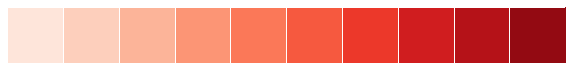

In [20]:
cmap1 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

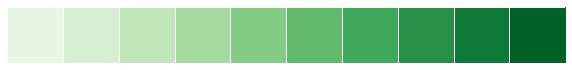

In [21]:
cmap2 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

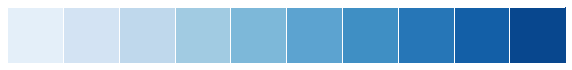

In [22]:
cmap3 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

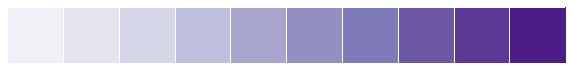

In [23]:
cmap4 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

The hybrid `BMC` algorithm creates a SOM cell. These cells are stored in the `cells` directory.

In [24]:
from matplotlib import gridspec

n_grid = 10
clens_som_cell = np.load('cells/cv_cells.0.npy')

# calculate mean values for each cell

def calc_cell_mean(x, som_cells, n_grid):
    x_cells = np.zeros(n_grid**2)
    for i in xrange(n_grid**2):
        i_cell = np.where(som_cells == i)
        x_cells[i] = x[i_cell].mean()
    
    return x_cells.reshape((n_grid, n_grid))

mag_i_cells = calc_cell_mean(train['MAG_i'].values, clens_som_cell, 10)
clr_u_g_cells = calc_cell_mean(train['u-g'].values, clens_som_cell, 10)
clr_g_r_cells = calc_cell_mean(train['g-r'].values, clens_som_cell, 10)
star_frac_cells = calc_cell_mean(truth_train, clens_som_cell, 10)

We plot a two-dimensional 10×10 SOM representation showing the mean $i$-band magnitude (top left), the fraction of true stars in each cell (top right), and the mean values of $u−g$ (bottom left) and $g−r$ (bottom right) for the cross-validation data.

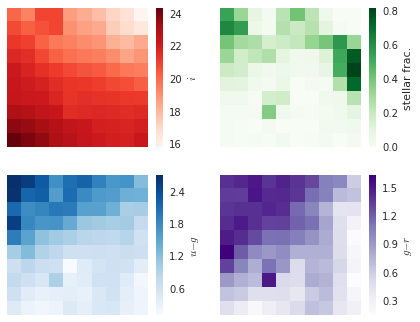

In [25]:
gs = gridspec.GridSpec(2, 3, height_ratios = (1, 1), width_ratios = (9, 9, 1))

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.matshow(mag_i_cells, cmap=cmap1)
ax1.set_xticks([])
ax1.set_yticks([])
cb1 = plt.colorbar(im1)
cb1.set_ticks([16, 18, 20, 22, 24])
cb1.set_label(r'$i$')

ax2 = plt.subplot(gs[0, 1])
im2 = ax2.matshow(star_frac_cells, cmap=cmap2)
ax2.set_xticks([])
ax2.set_yticks([])
cb2 = plt.colorbar(im2)
cb2.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cb2.set_label('stellar frac.')

ax3 = plt.subplot(gs[1, 0])
im3 = ax3.matshow(clr_u_g_cells, cmap=cmap3)
ax3.set_xticks([])
ax3.set_yticks([])
cb3 = plt.colorbar(im3)
cb3.set_ticks([0, 0.6, 1.2, 1.8, 2.4])
cb3.set_label(r'$u-g$')

ax4 = plt.subplot(gs[1, 1])
im4 = ax4.matshow(clr_g_r_cells, cmap=cmap4)
ax4.set_xticks([])
ax4.set_yticks([])
cb4 = plt.colorbar(im4)
cb4.set_label(r'$g-r$')
cb4.set_ticks([0.3, 0.6, 0.9, 1.2, 1.5])

plt.show()

The relative weights are stored in the `weights` directory. Using the weights, we also plot a two-dimensional 10×10 SOM representation showing the relative weights.

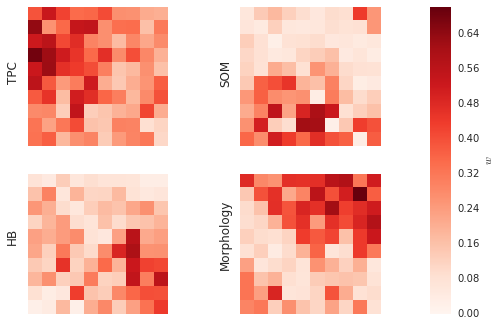

In [26]:
tpc_cells = np.zeros(n_grid**2)
som_cells = np.zeros(n_grid**2)
hbc_cells = np.zeros(n_grid**2)
morph_cells = np.zeros(n_grid**2)

for i in xrange(n_grid**2):
    
    weights = np.load('weights/bmc_weights.0.' + str(i) + '.npy')

    w = np.sum(weights, axis = 0)
    w = w / w.sum()

    tpc_cells[i] = w[0]
    som_cells[i] = w[1]
    hbc_cells[i] = w[2]
    morph_cells[i] = w[3]

tpc_cells = tpc_cells.reshape((n_grid, n_grid))
som_cells = som_cells.reshape((n_grid, n_grid))
hbc_cells = hbc_cells.reshape((n_grid, n_grid))
morph_cells = morph_cells.reshape((n_grid, n_grid))

gs = gridspec.GridSpec(2, 3, height_ratios = (1, 1), width_ratios = (9, 9, 1))

vmax = np.max([tpc_cells, som_cells, hbc_cells, morph_cells])
rotation = 'vertical'

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.matshow(tpc_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax1.set_title('TPC', rotation = rotation, x = -0.1, y = 0.5)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(gs[0, 1])
ax2.matshow(som_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax2.set_title('SOM', rotation = rotation, x = -0.1, y = 0.5)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = plt.subplot(gs[1, 0])
ax3.matshow(hbc_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax3.set_title('HB', rotation = rotation, x = -0.1, y = 0.5)
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = plt.subplot(gs[1, 1])
ax4.matshow(morph_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax4.set_title('Morphology', rotation = rotation, x = -0.1, y = 0.7)
ax4.set_xticks([])
ax4.set_yticks([])

ax5 = plt.subplot(gs[0:, 2])
cb1 = plt.colorbar(im1, cax=ax5)
cb1.set_label(r'$w$')
cb1.set_clim([0, vmax])

plt.show()